# Application: Blackbody Radiation

The spectrum of a star is well approximated as a [blackbody](https://en.wikipedia.org/wiki/Black-body_radiation). The Planck function describes the intensity of a blackbody:
    
$$B_\lambda = \frac{2 h c^2}{\lambda^5} \frac{1}{\exp\left (\frac{hc}{\lambda k_B T}\right) - 1}$$

This has units of energy / area / wavelength / steradian.  

## Integrating over wavelength
Let's integrate out wavelength:

$$B = \int_0^\infty B_\lambda d\lambda$$

our integral is then:

$$B = 2 h c^2 \int_0^\infty \frac{1}{\lambda^5} \frac{1}{\exp\left (\frac{hc}{\lambda k_B T}\right) - 1} d\lambda$$

defining a dimensional quantity, $x$:

$$x = \frac{hc}{\lambda k_B T}$$

we have

$$dx = - \frac{hc}{\lambda^2 k_B T} d\lambda = - \frac{x^2k_BT}{hc} d\lambda$$

finally, we have:

$$B = \frac{2(k_B T)^4}{h^3 c^2} \int_0^\infty \frac{x^3}{e^x - 1} dx$$

## Integrating to infinity

Now the challenge becomes &mdash; how do we do this integral, when the integration limits extend to infinity!

Note: it turns out that this integral has an analytic solution:

$$\int_0^\infty \frac{x^3}{e^x - 1} dx = \frac{\pi^4}{15}$$

and the original integral is

$$B = \frac{\sigma T^4}{\pi}$$

with the [Stephan-Boltzmann constant](https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_constant) defined as:

$$\sigma \equiv \frac{2 k_B^4 \pi^5}{15 h^3 c^2}$$

so we can check our answer.

It's always a good idea to start by plotting the integrand.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    # we need to take the limit x -> 0 if the input x is 0
    return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))

/tmp/ipykernel_1125604/922372595.py:3: RuntimeWarning: invalid value encountered in true_divide
  return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))


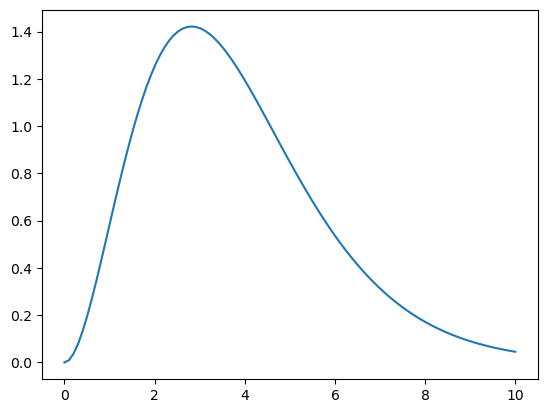

In [3]:
fig = plt.figure()
ax = fig.add_subplot()

x = np.linspace(0, 10, 100)
ax.plot(x, f(x))

From the plot, we see that it peaks near x = 3 and then drops off, but it will only asymptotically approach `0`, so we need to still be careful about the integration limits.

Let's consider the transform:

$$z = \frac{x}{c + x}$$

where $c$ is chosen to be close to the maximum of the integrand.  This transformation maps the interval $x \in [0, \infty)$ into $z \in [0, 1)$ &mdash; that makes the integral finite, and we can use our methods (like trapezoid) to do it.

The inverse transform is:

$$x = c \frac{z}{1 - z}$$

In [4]:
SMALL = 1.e-30

def zv(x, c):
    """ transform the variable x -> z """
    return x/(c + x) 

def xv(z, c):
    """ transform back from z -> x """
    return c*z/(1.0 - z + SMALL)

Let's plot it again, but in terms of $z$

/tmp/ipykernel_1125604/922372595.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))
/tmp/ipykernel_1125604/922372595.py:3: RuntimeWarning: invalid value encountered in true_divide
  return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))


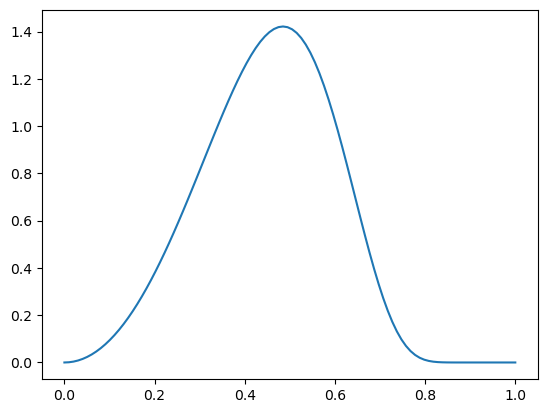

In [5]:
z = np.linspace(0, 1, 100)
c = 3

ax.clear()
ax.plot(z, f(xv(z, c)))
fig

Notice that the transform puts the peak near the center of the interval, and the function nicely goes to zero as $z\rightarrow 1$.  This is much better behaved to integrate.

Consider a general integral:

$$I = \int_0^\infty f(x) dx$$

Let's rewrite this in terms of $z$. Since

$$x = c \frac{z}{1 - z}$$

we have

$$dx = \frac{c dz}{(1 - z)^2}$$

so

$$I = c \int_0^1 f\left(c \frac{z}{1 - z} \right ) (1 -z)^{-2} dz$$

We need to include these extra factors in our quadrature for computing the integral.

In [6]:
def I_t(func, N=10, c=5):
    """composite trapezoid rule for integrating from [0, oo].
    Here N is the number of intervals"""
    
    # there are N+1 points corresponding to N intervals
    z = np.linspace(0.0, 1.0, N+1, endpoint=True)
    
    I = 0.0
    for n in range(N):
        I += 0.5 * (z[n+1] - z[n]) * (func(xv(z[n], c)) / (1.0 - z[n] + SMALL)**2 +
                                      func(xv(z[n+1], c)) / (1.0 - z[n+1] + SMALL)**2)
    I *= c
    return I

Now we can check our result.  First, let's compute the analytic solution:

In [7]:
I_analytic = np.pi**4/15

In [8]:
for nint in [2, 4, 8, 16, 32, 64]:
    I_trap = I_t(f, N=nint, c=3)
    print(f"{nint:5} {I_trap:10.5f} {np.abs(I_trap - I_analytic):20.10g}")

    2    8.48810          1.994163429
    4    6.09974         0.3941968295
    8    6.49205       0.001888841238
   16    6.49392      1.669019097e-05
   32    6.49394      5.396286928e-07
   64    6.49394      3.352448719e-08


/tmp/ipykernel_1125604/922372595.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))
/tmp/ipykernel_1125604/922372595.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x == 0, 0, x**3 / (np.exp(x) - 1))


We see that our answer matches the analytic solution very well.

## C++ implementation

A C++ implementation is available here: https://github.com/zingale/computational_astrophysics/blob/main/examples/integration/blackbody.cpp